In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf

In [3]:
# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# List physical GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
for gpu in gpus:
    print(gpu)

TensorFlow version: 2.10.0
Num GPUs Available:  1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras import Sequential

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

from tensorflow.keras.applications import EfficientNetB0

from tensorflow.keras.applications.efficientnet import preprocess_input

from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

In [5]:
from matplotlib import pyplot as plt

In [6]:
base = EfficientNetB0(
    weights='imagenet',
    include_top=False,
input_shape=(256, 256, 3)
)

In [7]:
base.trainable = False

In [8]:
batch_size=8
target_image_size=(256, 256)

In [9]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,              
    horizontal_flip=True,        
    fill_mode='nearest'
)

In [10]:
orig_images = ImageDataGenerator(
).flow_from_directory(
    directory=r'C:\Users\write\Desktop\skin_disease\dataset\Train',
    target_size=target_image_size,
    batch_size=batch_size,
    class_mode='sparse'
)

Found 2239 images belonging to 9 classes.


In [11]:
aug_images = datagen.flow_from_directory(
    directory = r'C:\Users\write\Desktop\skin_disease\dataset\Train',
    target_size=target_image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

Found 2239 images belonging to 9 classes.


In [12]:
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [13]:
validation_data = val_datagen.flow_from_directory(
    directory=r'C:\Users\write\Desktop\skin_disease\dataset\Test',
    target_size=target_image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)





# validation_data = image_dataset_from_directory(
#     directory=r'C:\Users\write\Desktop\skin_disease\dataset\Test',
#     labels='inferred',
#     label_mode='int',
#     batch_size=batch_size,
#     image_size=target_image_size
# )

Found 118 images belonging to 9 classes.


In [14]:
def combined_generator(g1, g2):
    while True:
        x1, y1 = g1.next()
        x2, y2 = g2.next()

        yield (np.concatenate([x1, x2]), np.concatenate([y1, y2]))

In [15]:
train_gen = combined_generator(aug_images, orig_images)

In [16]:
train_gen

<generator object combined_generator at 0x00000147C19FAC00>

#### For Saving Images

In [17]:
# aug_images = datagen.flow_from_directory(
#     directory=r'C:\Users\write\Desktop\skin_disease\dataset\Train',
#     target_size=target_image_size,
#     save_to_dir=r'C:\Users\write\Desktop\skin_disease\delete',
#     save_format='jpeg'
# )

# Model Training

In [18]:
model = Sequential()

In [19]:
# model.add(Conv2D(16, kernel_size=(3, 3), input_shape=(256, 256, 3)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.3))

# model.add(Conv2D(32, kernel_size=(3, 3)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.3))

# model.add(Conv2D(64, kernel_size=(3, 3)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

In [20]:
model.add(base)

In [21]:
model.add(GlobalAveragePooling2D())

In [22]:
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(9, activation='softmax'))

In [23]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4

In [25]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [26]:
csv_logger = CSVLogger('training_log.csv')

In [27]:
history = model.fit(train_gen, epochs=50, verbose='auto', steps_per_epoch=100, validation_data=validation_data, callbacks=[early_stop, csv_logger])

Epoch 1/50
100/100 [==============================] - 94s 744ms/step - loss: 2.6061 - sparse_categorical_accuracy: 0.1813 - val_loss: 1.8474 - val_sparse_categorical_accuracy: 0.2966
Epoch 2/50
100/100 [==============================] - 72s 725ms/step - loss: 2.1319 - sparse_categorical_accuracy: 0.2750 - val_loss: 1.9367 - val_sparse_categorical_accuracy: 0.2966
Epoch 3/50
100/100 [==============================] - 68s 690ms/step - loss: 1.9919 - sparse_categorical_accuracy: 0.3098 - val_loss: 1.7328 - val_sparse_categorical_accuracy: 0.3475
Epoch 4/50
100/100 [==============================] - 72s 724ms/step - loss: 1.7872 - sparse_categorical_accuracy: 0.3700 - val_loss: 1.6941 - val_sparse_categorical_accuracy: 0.3729
Epoch 5/50
100/100 [==============================] - 84s 837ms/step - loss: 1.6357 - sparse_categorical_accuracy: 0.4238 - val_loss: 1.6763 - val_sparse_categorical_accuracy: 0.3644
Epoch 6/50
100/100 [==============================] - 75s 754ms/step - loss: 1.6026 -

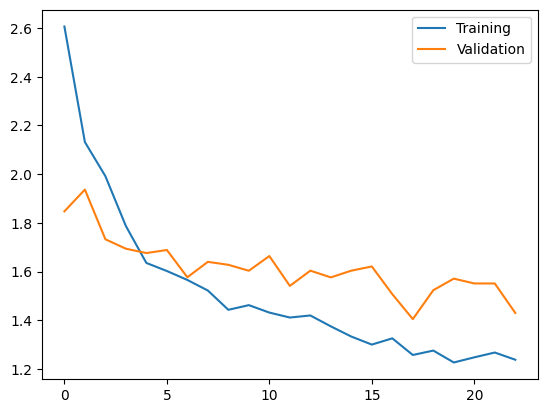

In [28]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

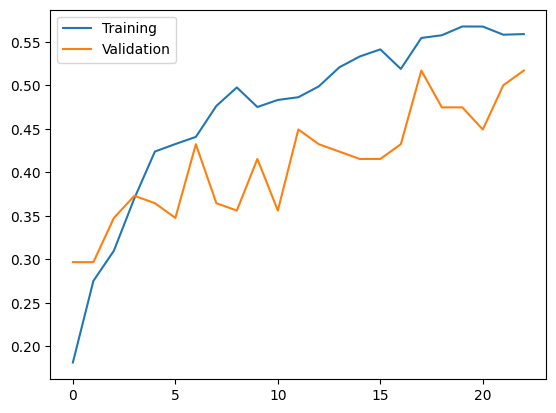

In [29]:
plt.plot(history.history['sparse_categorical_accuracy'], label='Training')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation')
plt.legend()
plt.show()

# Saving The Model

In [30]:
# Save weights to an H5 file
model.save_weights("model_weights.h5")


# loading the model

In [31]:
model = Sequential()
model.add(base)
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(9, activation='softmax'))

In [33]:
model.load_weights("model_weights.h5")

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 128)               163968    
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)               